## Importing necessary Modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import yeojohnson
from sklearn.metrics import roc_auc_score , roc_curve
from sklearn.preprocessing import LabelEncoder , StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split , cross_val_score ,KFold , GridSearchCV
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,mean_absolute_error , classification_report
%matplotlib inline

## Loading the Dataset

In [2]:
df=pd.read_csv("seattle-weather.csv")
df.head()

,date,precipitation,temp_max,temp_min,wind,weather
0,2012-01-01,0.0,12.8,5.0,4.7,drizzle
1,2012-01-02,10.9,10.6,2.8,4.5,rain
2,2012-01-03,0.8,11.7,7.2,2.3,rain
3,2012-01-04,20.3,12.2,5.6,4.7,rain
4,2012-01-05,1.3,8.9,2.8,6.1,rain


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1461 entries, 0 to 1460
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           1461 non-null   object 
 1   precipitation  1461 non-null   float64
 2   temp_max       1461 non-null   float64
 3   temp_min       1461 non-null   float64
 4   wind           1461 non-null   float64
 5   weather        1461 non-null   object 
dtypes: float64(4), object(2)
memory usage: 68.6+ KB


In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
precipitation,1461.0,3.029432,6.680194,0.0,0.0,0.0,2.8,55.9
temp_max,1461.0,16.439083,7.349758,-1.6,10.6,15.6,22.2,35.6
temp_min,1461.0,8.234771,5.023004,-7.1,4.4,8.3,12.2,18.3
wind,1461.0,3.241136,1.437825,0.4,2.2,3.0,4.0,9.5


### Checking for Duplicates

In [5]:
df.duplicated().sum()

0

### Checking for NULL values

In [6]:
df.isnull().sum()

date             0
precipitation    0
temp_max         0
temp_min         0
wind             0
weather          0
dtype: int64

In [7]:
df1 = df.copy()
df1['month'] = pd.to_datetime(df['date']).dt.month
df1['day'] = pd.to_datetime(df['date']).dt.day
df1['year'] = pd.to_datetime(df['date']).dt.year

## EDA

In [8]:
num_features = ['precipitation', 'temp_max', 'temp_min', 'wind']

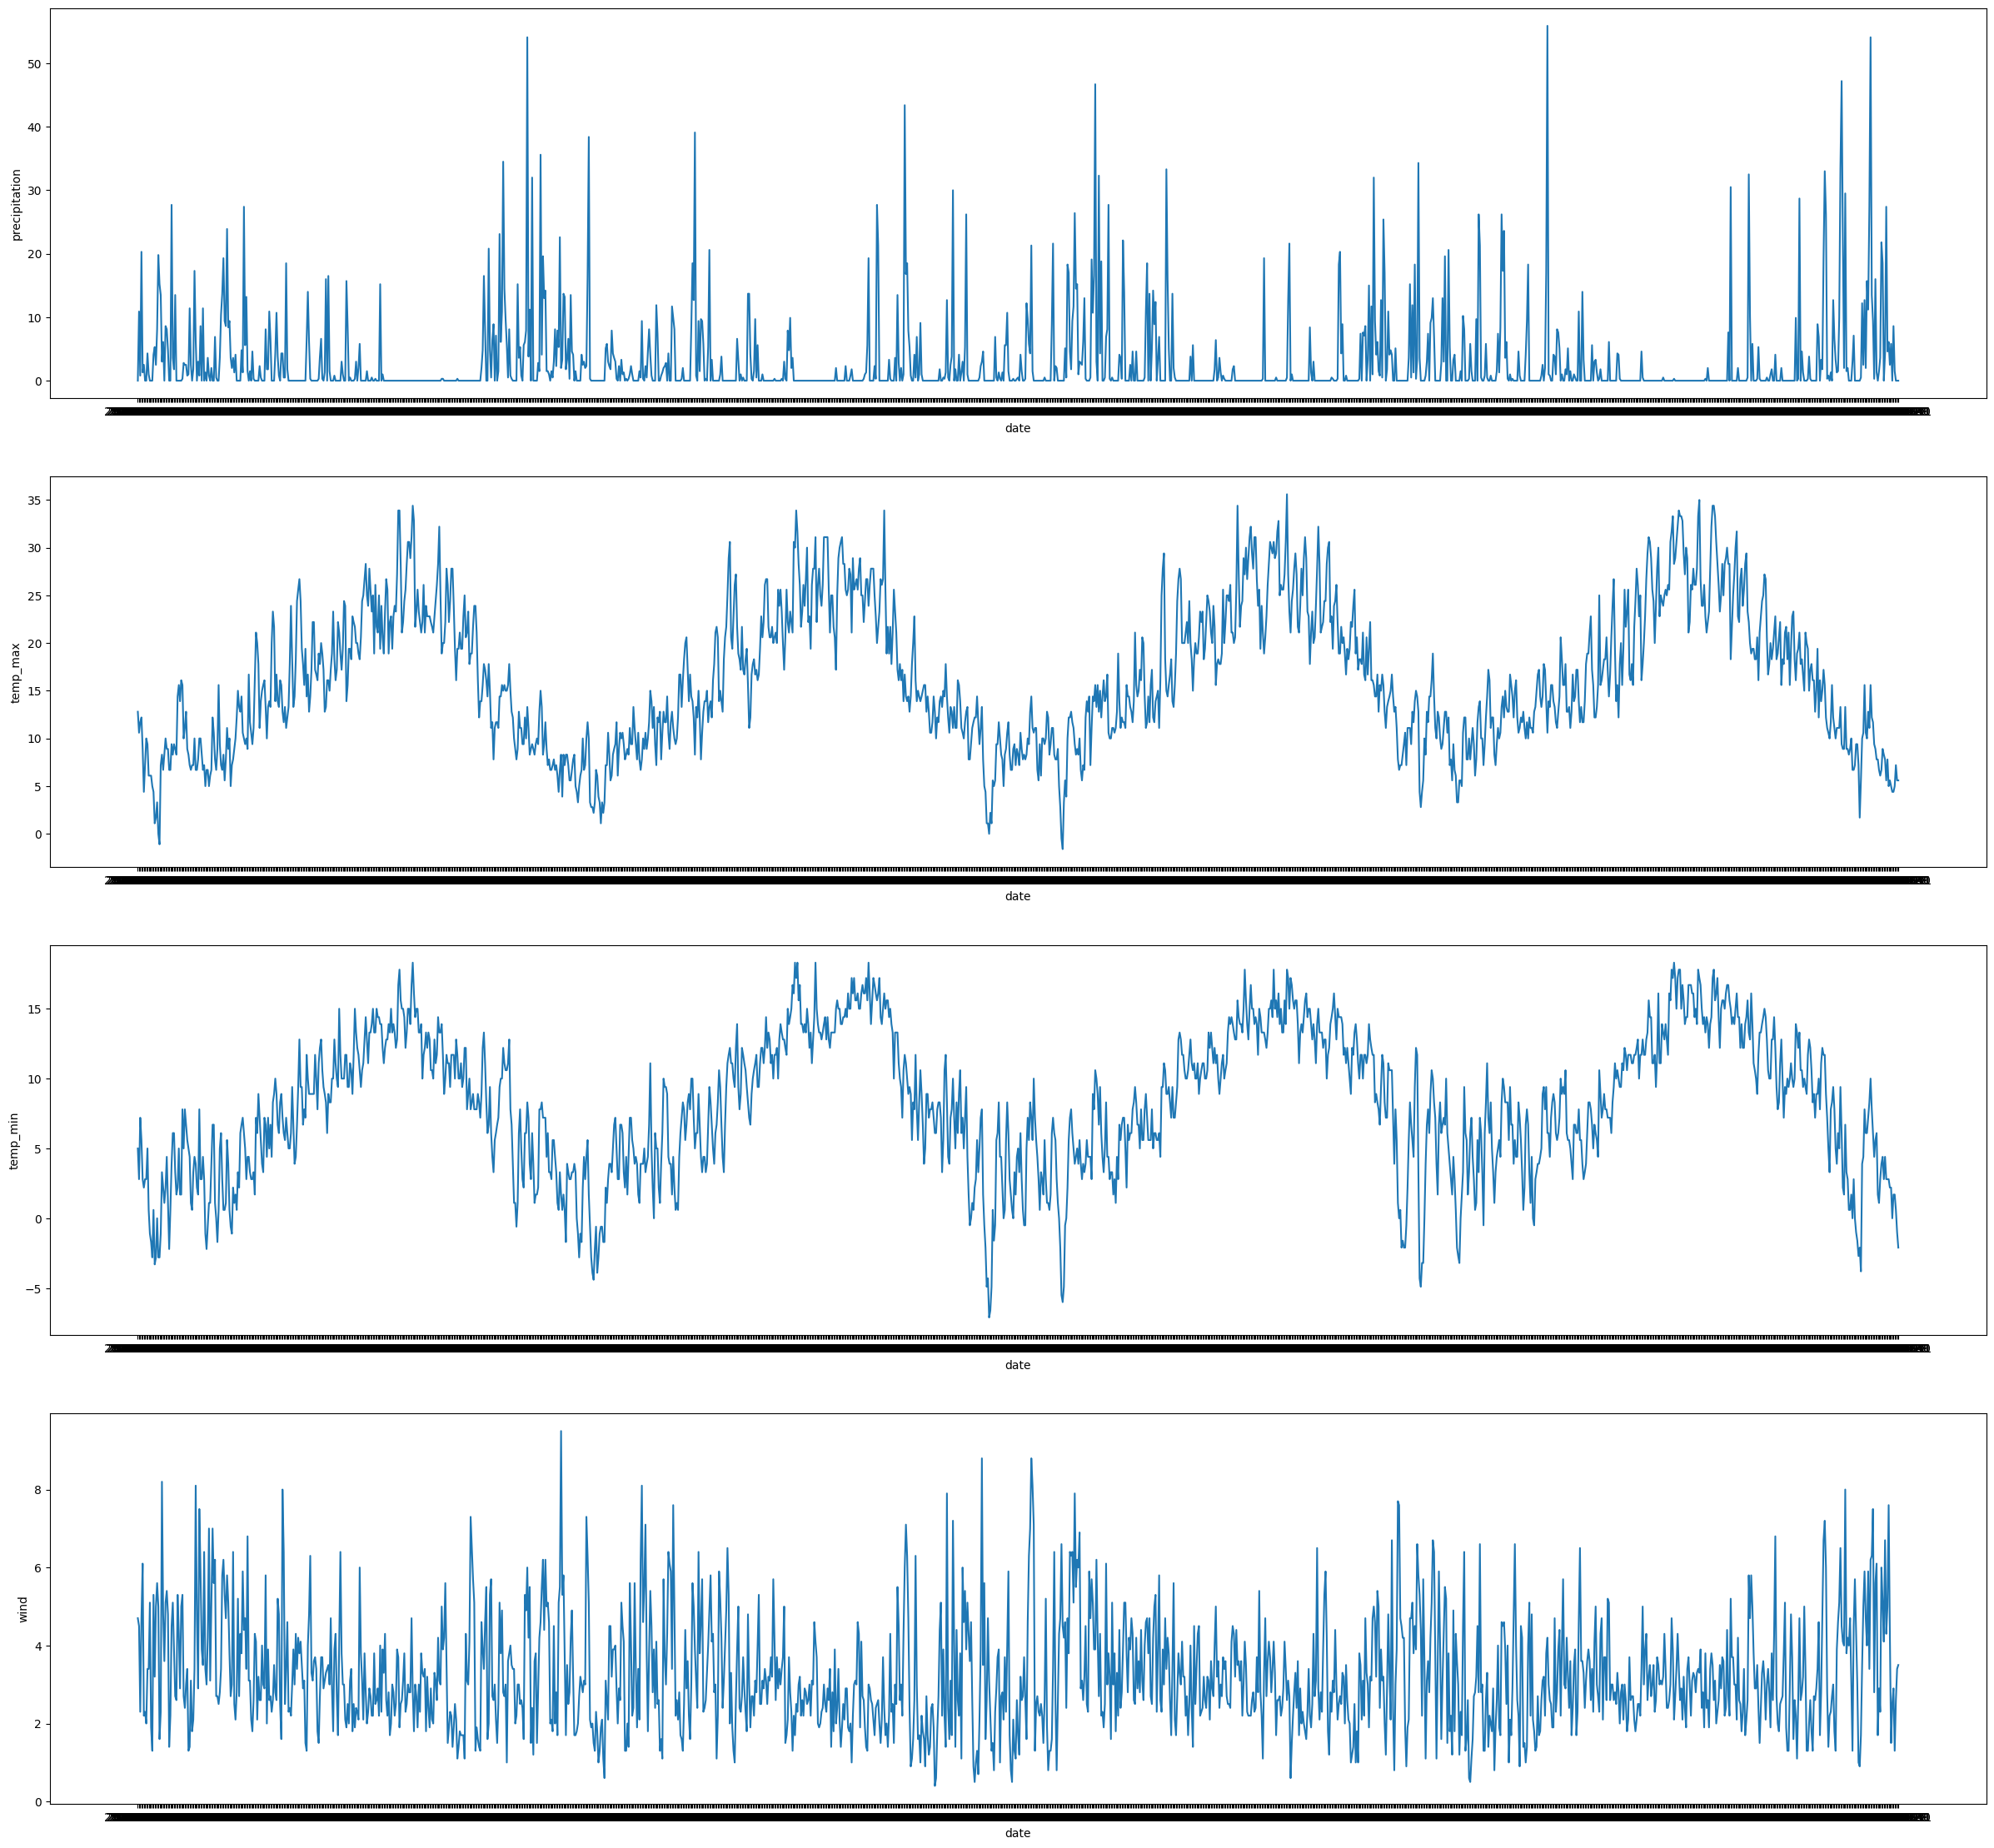

In [9]:
plt.figure(figsize=(30,28))
plt.subplot(4,1,1)
sns.lineplot(x=df['date'] ,y=df['precipitation'])
plt.subplot(4,1,2)
sns.lineplot(x=df['date'] ,y=df['temp_max'])
plt.subplot(4,1,3)
sns.lineplot(x=df['date'] ,y=df['temp_min'])
plt.subplot(4,1,4)
sns.lineplot(x=df['date'] ,y=df['wind'])
plt.show()

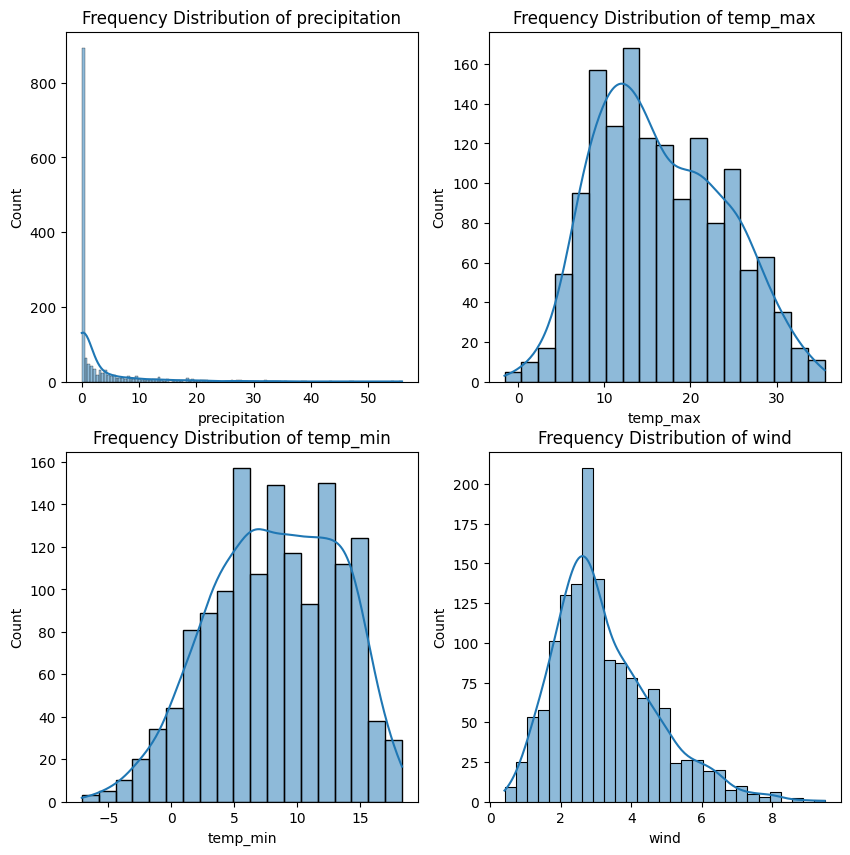

In [10]:
plt.figure(figsize=(10,10))
for loc , feature in enumerate(num_features):
    plt.subplot(2,2,loc+1)
    plt.title(f"Frequency Distribution of {feature}")
    sns.histplot(data = df , x = feature , kde = True)
plt.show()

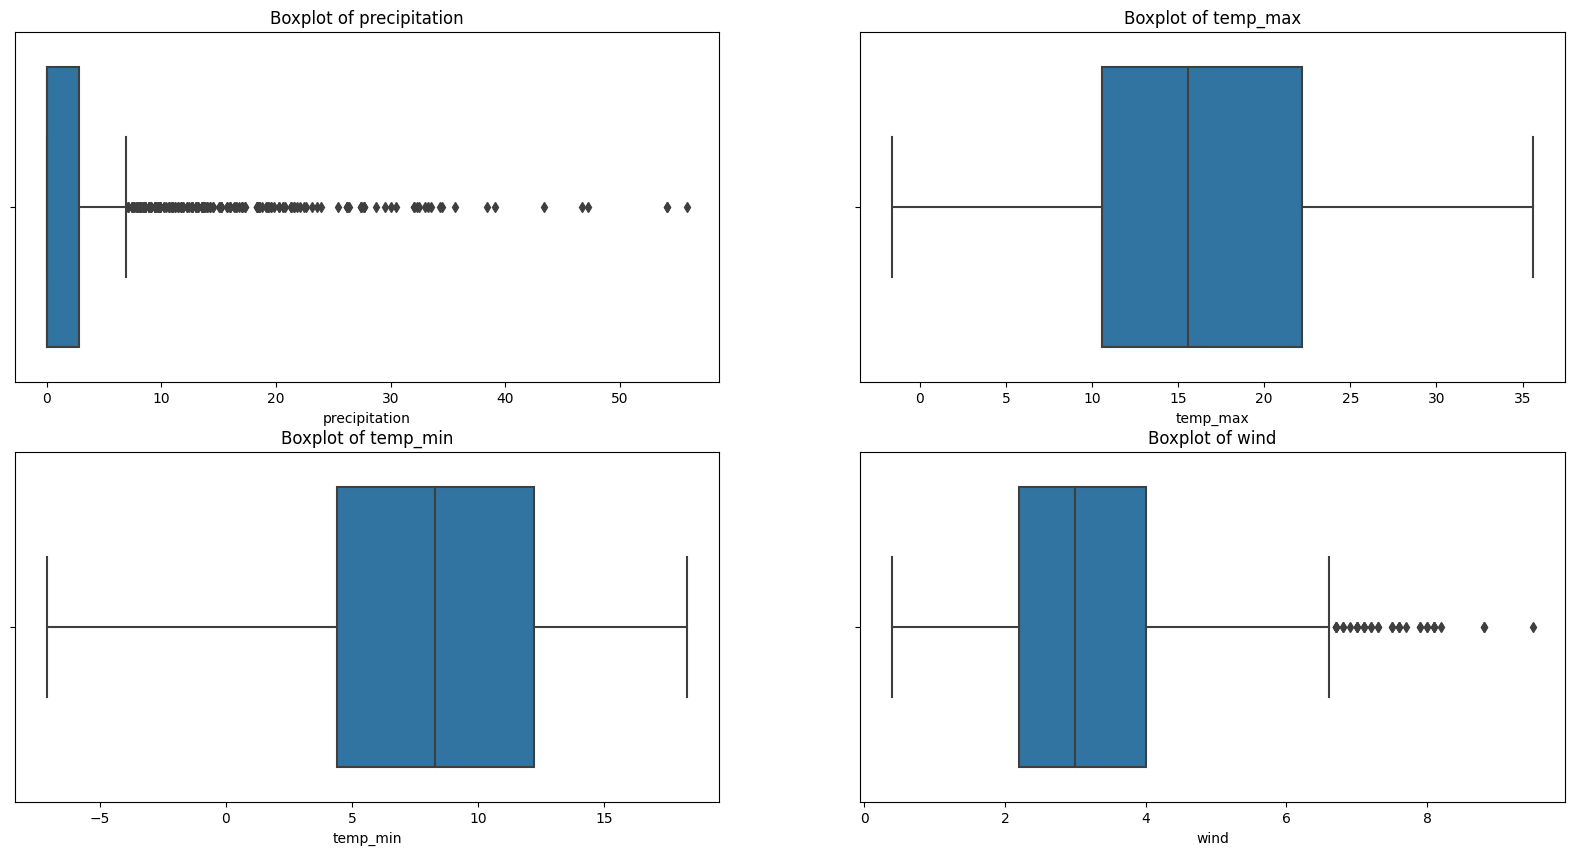

In [11]:
plt.figure(figsize=(20,10))
for loc , feature in enumerate(num_features):
    plt.subplot(2,2,loc+1)
    plt.title(f"Boxplot of {feature}")
    sns.boxplot(data = df , x = feature)
plt.show()

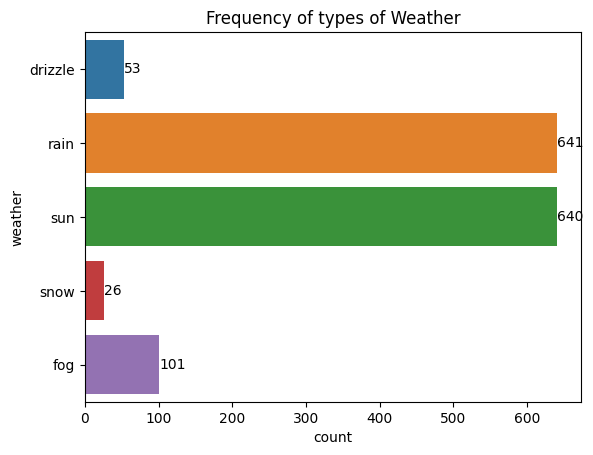

In [12]:
ax = sns.countplot(data = df , y = 'weather')
ax.bar_label(ax.containers[0])
plt.title("Frequency of types of Weather")
plt.show()

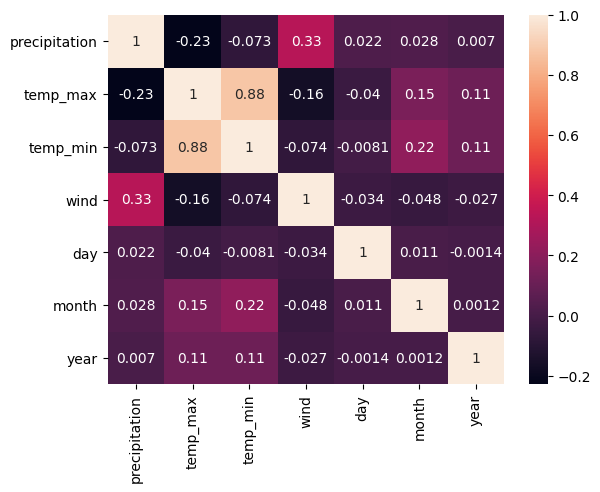

In [13]:
sns.heatmap(df1[num_features+['day','month','year']].corr(),annot=True)
plt.show()

<Figure size 1000x1000 with 0 Axes>

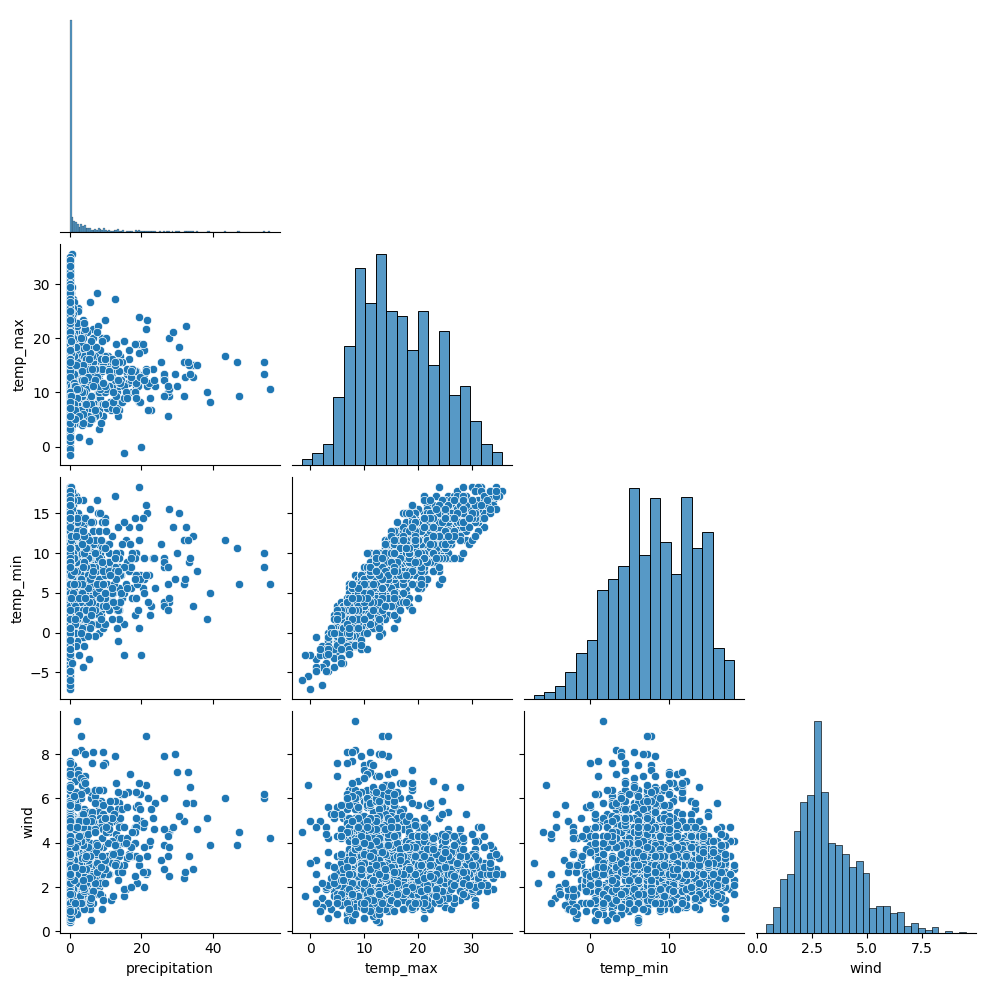

In [14]:
plt.figure(figsize=(10,10))
sns.pairplot(df[num_features] , corner=True)
plt.show()

### Handling skewness in Precipitaion

In [15]:
df1['log_precipitation'] = np.log1p(df1['precipitation'])

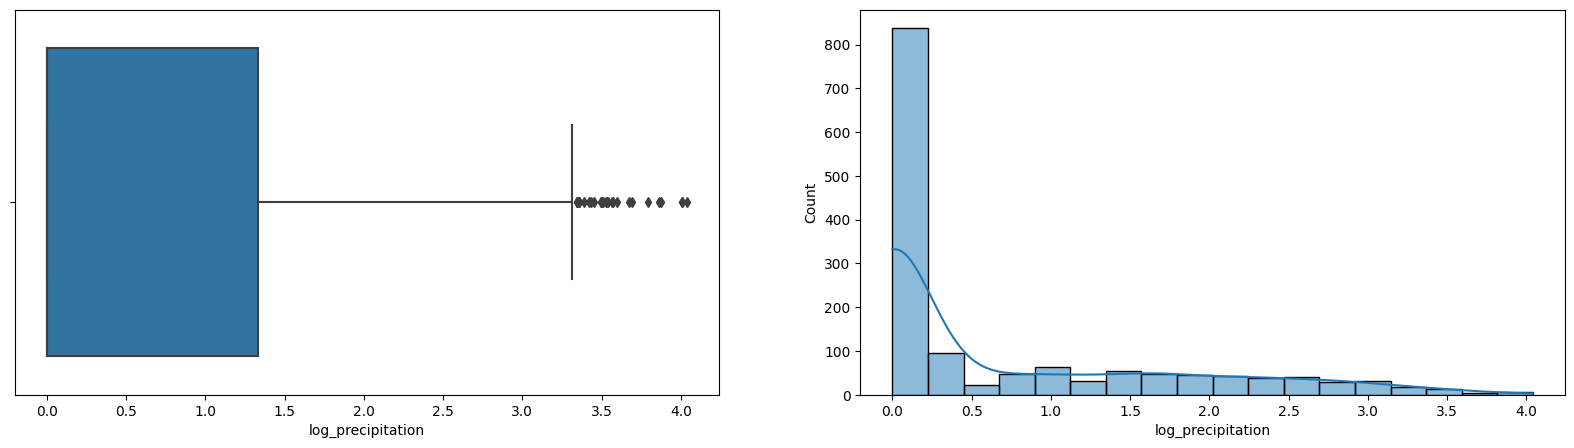

In [16]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
sns.boxplot(data = df1 , x = 'log_precipitation')
plt.subplot(1,2,2)
sns.histplot(data = df1 , x = 'log_precipitation',kde=True)
plt.show()

In [17]:
print(f"Original Skewness ---> {df1['precipitation'].skew() : .4f}")
print(f"Skewness after log1p transformation ---> {df1['log_precipitation'].skew() : .4f}")

Original Skewness --->  3.5056
Skewness after log1p transformation --->  1.2735


## RandomForestClassifier

In [18]:
X=df1[['log_precipitation', 'temp_max', 'temp_min', 'wind' , 'day' , 'month' , 'year']].values
y=df1['weather'].values

### Label Encoding the weather

In [19]:
le1=LabelEncoder()
y=le1.fit_transform(y)

In [20]:
index=list(le1.inverse_transform([0,1,2,3,4]))
print("Label\t Weather")
for i in range(5):
    print(' ',i,'\t',index[i])

Label	 Weather
  0 	 drizzle
  1 	 fog
  2 	 rain
  3 	 snow
  4 	 sun


### Splitting the training and testing sets

In [21]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

### Scaling the inputs

In [22]:
sc=StandardScaler()
X_train=sc.fit_transform(X_train)
X_test=sc.transform(X_test)

In [23]:
X_train

array([[-0.68843557, -1.48337156, -2.29332143, ..., -1.54960835,
         1.60943041,  0.44021798],
       [ 2.2092162 , -0.34592487,  0.34906529, ...,  1.62354245,
         0.73441968, -0.44935745],
       [ 2.22410968, -0.57889588, -0.43163988, ..., -0.64299383,
        -1.01560178,  0.44021798],
       ...,
       [-0.29290266, -0.11295386, -0.21144098, ..., -0.64299383,
        -0.43226129,  0.44021798],
       [-0.68843557, -1.48337156, -1.85292364, ...,  1.62354245,
         1.60943041,  1.3297934 ],
       [-0.68843557, -1.26410473, -0.99214615, ...,  1.73686926,
        -1.59894227,  1.3297934 ]])

In [24]:
y_train

array([1, 2, 2, ..., 2, 4, 1])

### Making the model

In [25]:
clf=RandomForestClassifier(n_estimators=100,random_state=42,class_weight='balanced')
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)
print(f"Test Accuracy ---> {clf.score(X_test,y_test) : .4f}")

Test Accuracy --->  0.8532


### 10-Fold CrossValidation scores

In [26]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)
fold_accuracies = []

for fold, (train_index, test_index) in enumerate(kf.split(X), start=1):
    Xf_train, Xf_test = X[train_index], X[test_index]
    yf_train, yf_test = y[train_index], y[test_index]
    
    rclf = RandomForestClassifier(n_estimators=100,random_state=42)
    rclf.fit(Xf_train, yf_train)
    
    yf_pred = rclf.predict(Xf_test)
    accuracy = rclf.score(Xf_test,yf_test)
    fold_accuracies.append(accuracy)
    
    print(f"Fold {fold} : Accuracy ---> {accuracy:.4f}")

print(f"Mean cross-validation accuracy ---> {np.mean(fold_accuracies):.4f}")
print(f"Standard deviation of accuracy ---> {np.std(fold_accuracies):.4f}")

Fold 1 : Accuracy ---> 0.8776
Fold 2 : Accuracy ---> 0.8493
Fold 3 : Accuracy ---> 0.8562
Fold 4 : Accuracy ---> 0.8973
Fold 5 : Accuracy ---> 0.8082
Fold 6 : Accuracy ---> 0.8562
Fold 7 : Accuracy ---> 0.8356
Fold 8 : Accuracy ---> 0.8630
Fold 9 : Accuracy ---> 0.8425
Fold 10 : Accuracy ---> 0.9247
Mean cross-validation accuracy ---> 0.8610
Standard deviation of accuracy ---> 0.0310


### ROC_AUC metrics

In [27]:
y_pred_proba = clf.predict_proba(X_test)
print(f"ROC_AUC score using One-vs-the-Rest (OvR) multiclass strategy ---> {roc_auc_score(y_test,y_pred_proba,multi_class='ovr'):.4f}")
print(f"ROC_AUC score using One-vs-One (OvO) multiclass strategy ---> {roc_auc_score(y_test,y_pred_proba,multi_class='ovo'):.4f}")

ROC_AUC score using One-vs-the-Rest (OvR) multiclass strategy ---> 0.9409
ROC_AUC score using One-vs-One (OvO) multiclass strategy ---> 0.9336


### Classification Report

In [28]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      0.22      0.36         9
           1       0.75      0.24      0.36        25
           2       0.94      0.93      0.93       120
           3       0.33      0.12      0.18         8
           4       0.80      0.99      0.89       131

    accuracy                           0.85       293
   macro avg       0.77      0.50      0.55       293
weighted avg       0.85      0.85      0.83       293



### Confusion matrix

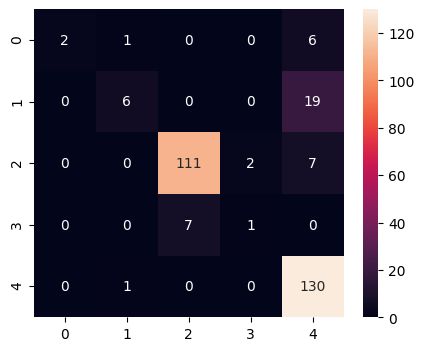

In [29]:
plt.figure(figsize=(5,4))
cm=confusion_matrix(y_test,y_pred)
sns.heatmap(cm , annot = True , fmt = 'g')
plt.show()

## HyperParameter Tuning using GridSearchCV

In [30]:
param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [80, 90, 100, 110],
    'min_samples_split': [5, 8, 10],
    'min_samples_leaf': [3, 4, 5],
    'bootstrap': [True, False],
    'class_weight' : ['balanced']
}

grid_search = GridSearchCV(
    estimator=clf,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 864 candidates, totalling 4320 fits


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=42),
             n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'class_weight': ['balanced'],
                         'max_depth': [80, 90, 100, 110],
                         'max_features': ['sqrt', 'log2', None],
                         'min_samples_leaf': [3, 4, 5],
                         'min_samples_split': [5, 8, 10],
                         'n_estimators': [50, 100, 150, 200]},
             scoring='accuracy', verbose=1)

In [31]:
print("Best Parameters:", grid_search.best_params_)
print(f"Best Cross-Validation Accuracy ---> {grid_search.best_score_: .4f}")

best_model = grid_search.best_estimator_
test_accuracy = best_model.score(X_test, y_test)
print(f"Test Set Accuracy ---> {test_accuracy : .4f}")

Best Parameters: {'bootstrap': True, 'class_weight': 'balanced', 'max_depth': 80, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 50}
Best Cross-Validation Accuracy --->  0.8476
Test Set Accuracy --->  0.8362


### Classification Report after HyperParameter Tuning

In [37]:
best_model.fit(X_train,y_train)
by_pred = best_model.predict(X_test)
print(classification_report(y_test,by_pred))

              precision    recall  f1-score   support

           0       0.36      0.44      0.40         9
           1       0.55      0.44      0.49        25
           2       0.96      0.91      0.94       120
           3       0.62      0.62      0.62         8
           4       0.82      0.89      0.85       131

    accuracy                           0.84       293
   macro avg       0.67      0.66      0.66       293
weighted avg       0.84      0.84      0.84       293



### ROC_AUC score after HyperParameter Tuning

In [38]:
by_pred_proba = best_model.predict_proba(X_test)
print(f"ROC_AUC score using One-vs-the-Rest (OvR) multiclass strategy ---> {roc_auc_score(y_test,by_pred_proba,multi_class='ovr'):.4f}")
print(f"ROC_AUC score using One-vs-One (OvO) multiclass strategy ---> {roc_auc_score(y_test,by_pred_proba,multi_class='ovo'):.4f}")

ROC_AUC score using One-vs-the-Rest (OvR) multiclass strategy ---> 0.9491
ROC_AUC score using One-vs-One (OvO) multiclass strategy ---> 0.9468
